In [1]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
import numpy as np

In [2]:
seed = 256
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

1. Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3 datasets: training, validation and test.
Take a subset of these datasets by keeping only 2 labels: bird and plane.

In [3]:
def load_cifar10():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    return cifar10_train, cifar10_test

In [4]:
cifar10_train, cifar10_test = load_cifar10()
label_map = {0: 0, 2: 1}

cifar2_train = [(img, label_map[label]) for img, label in cifar10_train if label in [0, 2]]
cifar2_test = [(img, label_map[label]) for img, label in cifar10_test if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


In [5]:
num_train_total = len(cifar2_train)
num_train = int(0.8 * num_train_total)
num_val = num_train_total - num_train

cifar2_train, cifar2_val = random_split(cifar2_train, [num_train, num_val])

In [6]:
print("Train Size:", len(cifar2_train))
print("Validation Size:", len(cifar2_val))
print("Test Size:", len(cifar2_test))

Train Size: 8000
Validation Size: 2000
Test Size: 2000


In [7]:
for name, dataset in zip(['Train', 'Validation', 'Test'], [cifar2_train, cifar2_val, cifar2_test]):
    counts = [sum(label == i for _, label in dataset) for i in range(2)]
    print(f"{name}: {counts[0]} Airplanes, {counts[1]} Birds")

Train: 4009 Airplanes, 3991 Birds
Validation: 991 Airplanes, 1009 Birds
Test: 1000 Airplanes, 1000 Birds


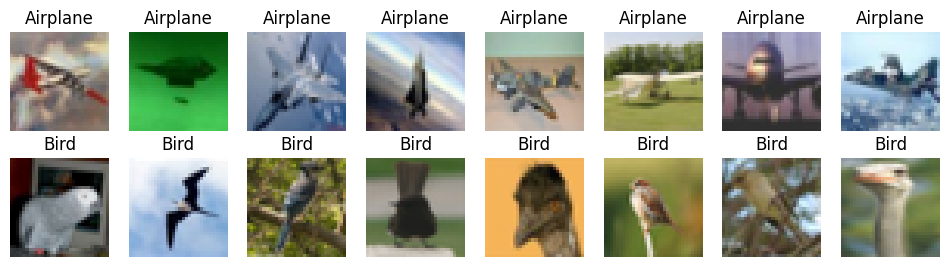

In [8]:
def show_imgs(imgs, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3))

    for i, (img, title) in enumerate(zip(imgs, titles)):
        img = img / 2 + 0.5
        npimg = img.numpy()
        row = i // cols
        col = i % cols
        axes[row, col].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

    plt.show()


airplane_indices = [i for i, (img, label) in enumerate(cifar2_train) if label == 0][:8]
bird_indices = [i for i, (img, label) in enumerate(cifar2_train) if label == 1][:8]

airplane_images = [cifar2_train[i][0] for i in airplane_indices]
bird_images = [cifar2_train[i][0] for i in bird_indices]

show_imgs(airplane_images + bird_images, ['Airplane'] * 8 + ['Bird'] * 8, rows=2, cols=8)

In [9]:
def set_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")
    return device

2. Write a `MyMLP` class that implements a MLP in PyTorch (so only fully connected layers) such that:
(a) The input dimension is 3072 (= 32 $\times$ 32 $\times$ 3) and the output dimension is 2 (for the 2 classes).
(b) The hidden layers have respectively 512, 128 and 32 hidden units.
(c) All activation functions are `ReLU`. The last layer has no activation function since the
cross-entropy loss already includes a softmax activation function.

In [10]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.flatten(x, 1)  # transforming into 1-dim vector 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

3. Write a `train(n_epochs, optimizer, model, loss_fn, train_loader)` function that trains model for `n_epochs`
epochs given an optimizer `optimizer`, a loss function `loss_fn` and a dataloader `train_loader`.

In [11]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    print(" --------- Using Pytorch's SGD ---------")

    train_losses = []
    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0
        # loop over batches
        for imgs, labels in train_loader:
            # retrieve inputs and labels for this batch
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch == 1 or epoch % 5 == 0:
            timestamp = datetime.now().strftime('%H:%M:%S.%f')
            avg_loss = epoch_loss / len(train_loader)
            print(f"{timestamp}  |  Epoch {epoch}  |  Training loss {round(avg_loss, 5)}")

        train_losses.append(epoch_loss / len(train_loader))

    return train_losses

4. Write a similar function `train_manual_update` that has no `optimizer` parameter, but a learning rate `lr` parameter instead and that manually updates each trainable parameter of `model` using equation (2). Do not forget to zero out all gradients after each iteration.
6. Modify `train_manual_update` by adding a L2 regularization term in your manual parameter update. Add an additional weight decay parameter to `train_manual_update`. Compare again `train` and `train_manual_update` results with 0 < `weight_decay` < 1.
7. Modify `train_manual_update` by adding a momentum term in your parameter update. Add an additional `momentum` parameter to `train_manual_update`. Check again the correctness of the new update rule by comparing it to train function (with 0 < `momentum` < 1).


[SGD PyTorch Pseudocode](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [12]:
def train_manual_update(n_epochs, lr, model, loss_fn, train_loader, weight_decay, momentum):
    print(" --------- Using manual update ----------")

    train_losses = []
    momentum_buffers = {name: torch.zeros_like(p.data) for name, p in model.named_parameters()}

    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0
        # loop over batches
        for imgs, labels in train_loader:
            # retrieve inputs and labels for this batch
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # forward + backward
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # manual parameter update using the gradient descent rule
            with torch.no_grad():
                for name, p in model.named_parameters():
                    grad = p.grad

                    # L2 regularization: adjust the gradient by adding weight_decay (L2 penalty) 
                    # times the parameters from the previous time step
                    grad += weight_decay * p.data

                    # compute the new buffer (accumulation of the gradient over time, scaled by 
                    # the momentum) using the previous buffer and the current gradient
                    buf = momentum_buffers[name]
                    buf.mul_(momentum).add_(grad)
                    grad = buf

                    # update the parameters, using the adjusted gradient and the learning rate lr
                    p.data -= lr * grad

            model.zero_grad()

            epoch_loss += loss.item()

        if epoch == 1 or epoch % 5 == 0:
            timestamp = datetime.now().strftime('%H:%M:%S.%f')
            avg_loss = epoch_loss / len(train_loader)
            print(f"{timestamp}  |  Epoch {epoch}  |  Training loss {round(avg_loss, 5)}")

        train_losses.append(epoch_loss / len(train_loader))

    return train_losses

In [13]:
def evaluate_accuracy(model, loader):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            # retrieve inputs and labels for this batch
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(imgs)

            # class with the highest value is what we choose as prediction
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [14]:
batch_size = 256

train_loader = DataLoader(cifar2_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(cifar2_test, batch_size=batch_size, shuffle=False)

In [15]:
n_epochs = 30
l_rate = [0.01] * 6
momentum = [0, 0, 0.9, 0.9, 0.9, 0.8]
weight_decay = [0, 0.01, 0, 0.01, 0.001, 0.01]

hyperparameters = [(lr, mom, decay) for lr, mom, decay in zip(l_rate, momentum, weight_decay)]

In [16]:
device = set_device()

Training on device cpu.


In [17]:
train_losses_model1 = []
train_accuracies_model1 = []
val_accuracies_model1 = []

train_losses_model2 = []
train_accuracies_model2 = []
val_accuracies_model2 = []

In [18]:
for lr, mom, decay in hyperparameters:
    print(" =========================================================")
    print(f"   Current parameters:\nlr = {lr}\nmom = {mom}\ndecay = {decay}\n")

    torch.manual_seed(seed)
    model1 = MyMLP().to(device)
    # construct SGD optimizer and initialize learning rate, momentum and weight decay
    optimizer = optim.SGD(model1.parameters(), lr=lr, momentum=mom, weight_decay=decay)
    loss_fn = nn.CrossEntropyLoss()

    train_losses1 = train(n_epochs, optimizer, model1, loss_fn, train_loader)
    train_accuracy_model1 = evaluate_accuracy(model1, train_loader)
    val_accuracy_model1 = evaluate_accuracy(model1, val_loader)

    train_losses_model1.append(train_losses1)
    train_accuracies_model1.append(train_accuracy_model1)
    val_accuracies_model1.append(val_accuracy_model1)

    print("\n --- Accuracies ---")
    print(f"Training\nAccuracy: {round(train_accuracy_model1, 2)}")
    print(f"Validation\nAccuracy: {round(val_accuracy_model1, 2)}\n")

    torch.manual_seed(seed)
    model2 = MyMLP().to(device)

    train_losses2 = train_manual_update(n_epochs, lr, model2, loss_fn, train_loader, decay, mom)
    train_accuracy_model2 = evaluate_accuracy(model2, train_loader)
    val_accuracy_model2 = evaluate_accuracy(model2, val_loader)

    train_losses_model2.append(train_losses2)
    train_accuracies_model2.append(train_accuracy_model2)
    val_accuracies_model2.append(val_accuracy_model2)

    print("\n --- Accuracies ---")
    print(f"Training\nAccuracy: {round(train_accuracy_model2, 2)}")
    print(f"Validation\nAccuracy: {round(val_accuracy_model2, 2)}\n")

   Current parameters:
lr = 0.01
mom = 0
decay = 0

 --------- Using Pytorch's SGD ---------
11:36:01.537066  |  Epoch 1  |  Training loss 0.69209
11:36:02.516166  |  Epoch 5  |  Training loss 0.64788
11:36:03.721058  |  Epoch 10  |  Training loss 0.55918
11:36:04.923066  |  Epoch 15  |  Training loss 0.49471
11:36:06.124984  |  Epoch 20  |  Training loss 0.46545
11:36:07.325765  |  Epoch 25  |  Training loss 0.4443
11:36:08.522816  |  Epoch 30  |  Training loss 0.42322

 --- Accuracies ---
Training
Accuracy: 0.82
Validation
Accuracy: 0.82

 --------- Using manual update ----------
11:36:09.015795  |  Epoch 1  |  Training loss 0.69209
11:36:10.277839  |  Epoch 5  |  Training loss 0.64788
11:36:11.850557  |  Epoch 10  |  Training loss 0.55918
11:36:13.430384  |  Epoch 15  |  Training loss 0.49471
11:36:15.005864  |  Epoch 20  |  Training loss 0.46545
11:36:16.594094  |  Epoch 25  |  Training loss 0.4443
11:36:18.924581  |  Epoch 30  |  Training loss 0.42322

 --- Accuracies ---
Training

In [24]:
accuracies = [train_accuracies_model1, train_accuracies_model2, val_accuracies_model1, val_accuracies_model2]
headers = ["Hyperparameters", "Train Acc Model 1", "Train Acc Model 2", "Val Acc Model 1", "Val Acc Model 2"]

print(tabulate(list(zip(hyperparameters, *accuracies)), headers=headers))

Hyperparameters       Train Acc Model 1    Train Acc Model 2    Val Acc Model 1    Val Acc Model 2
------------------  -------------------  -------------------  -----------------  -----------------
(0.01, 0, 0)                   0.823125             0.823125             0.8165             0.8165
(0.01, 0, 0.01)                0.8175               0.8175               0.8145             0.8145
(0.01, 0.9, 0)                 0.954                0.954                0.8255             0.8255
(0.01, 0.9, 0.01)              0.910875             0.910875             0.828              0.828
(0.01, 0.9, 0.001)             0.96325              0.96325              0.8445             0.8445
(0.01, 0.8, 0.01)              0.934625             0.934625             0.8515             0.8515


In [21]:
best_model_idx = val_accuracies_model1.index(max(val_accuracies_model1))

best_lr, best_mom, best_decay = hyperparameters[best_model_idx]
best_val_accuracy = val_accuracies_model1[best_model_idx]

print(f" --- Best Model ---")
print(f"Hyperparameters: lr={best_lr}, mom={best_mom}, decay={best_decay}")
print(f"Validation Accuracy: {best_val_accuracy}")

 --- Best Model ---
Hyperparameters: lr=0.01, mom=0.8, decay=0.01
Validation Accuracy: 0.8515


In [22]:
torch.manual_seed(seed)
model = MyMLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_mom, weight_decay=best_decay)
loss_fn = nn.CrossEntropyLoss()

# train the model using the best hyperparameters on the entire training dataset (2 options)
# best_train_losses = train(n_epochs, optimizer, model, loss_fn, train_loader)
best_train_losses = train_manual_update(n_epochs, best_lr, model, loss_fn, train_loader, best_decay, best_mom)

# evaluate the best model on the test dataset
model.eval()
test_accuracy = evaluate_accuracy(model, test_loader)

print(f"\nBest model hyperparameters: lr={best_lr}, mom={best_mom}, decay={best_decay}")
print(f"Test accuracy for the best model: {test_accuracy}")

 --------- Using manual update ----------
11:38:32.879257  |  Epoch 1  |  Training loss 0.68093
11:38:35.429761  |  Epoch 5  |  Training loss 0.47167
11:38:38.247007  |  Epoch 10  |  Training loss 0.39019
11:38:40.520236  |  Epoch 15  |  Training loss 0.31772
11:38:42.850903  |  Epoch 20  |  Training loss 0.2424
11:38:45.936781  |  Epoch 25  |  Training loss 0.17079
11:38:48.878685  |  Epoch 30  |  Training loss 0.20003

Best model hyperparameters: lr=0.01, mom=0.8, decay=0.01
Test accuracy for the best model: 0.849


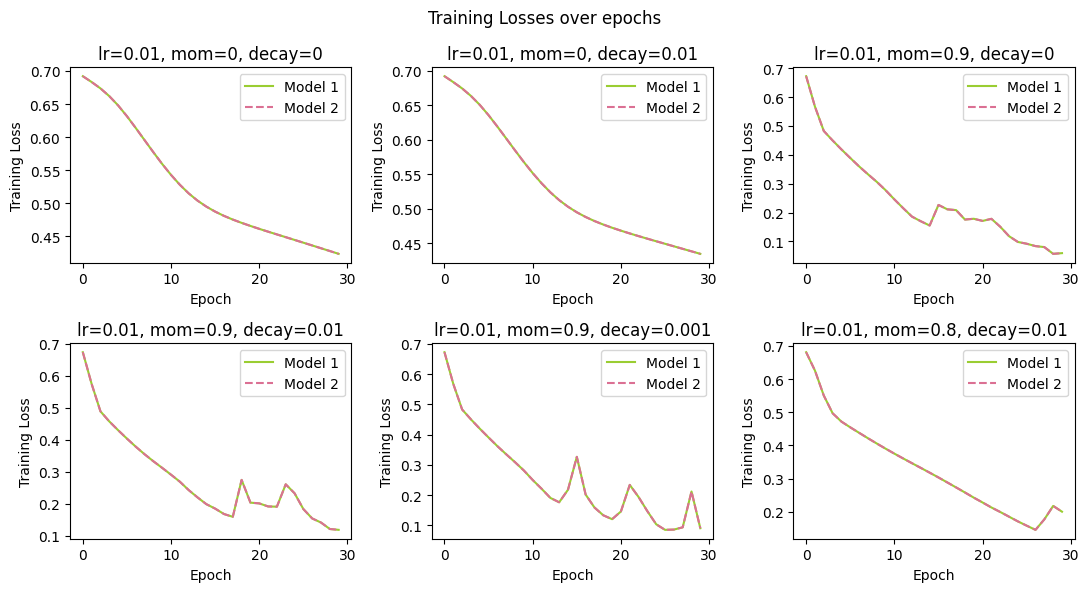

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))

for i, (lr, mom, decay) in enumerate(hyperparameters):
    row = i // 3
    col = i % 3

    axes[row, col].plot(train_losses_model1[i], label='Model 1', color="yellowgreen", linestyle='-')
    axes[row, col].plot(train_losses_model2[i], label='Model 2', color="palevioletred", linestyle='--')
    axes[row, col].set_title(f'lr={lr}, mom={mom}, decay={decay}')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Training Loss')
    axes[row, col].legend()

plt.suptitle('Training Losses over epochs')
plt.tight_layout()
plt.show()